# UK Research and the Sustainable Development Goals

This tutorial will explore the relationships between the United Nations Sustainable Development Goals (SDGs) and UK publicly funded research projects.

The tutorial consists of two segments:
1. Constructing a classifier to tag documents with SDG labels using supervised machine learning
2. Applying the classifier to UK research projects from Gateway to Research and performing analysis

## Preamble

In [1]:
%load_ext autoreload
%autoreload 2
# install im_tutorial package
"""!pip install git+https://github.com/nestauk/im_tutorials.git
!pip install annoy"""

'!pip install git+https://github.com/nestauk/im_tutorials.git\n!pip install annoy'

In [2]:
# useful Python tools
from itertools import chain, combinations
from collections import Counter

# matplotlib for static plots
import matplotlib.pyplot as plt
import matplotlib

# networkx for networks
import networkx as nx

# numpy for mathematical functions
import numpy as np

# pandas for handling tabular data
import pandas as pd

# seaborn for pretty statistical plots
import seaborn as sns

pd.set_option('max_columns', 99)

# basic bokeh imports for an interactive scatter plot or line chart
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Circle, Line

# NB: If using Google Colab, this function must be run at 
# the end of any cell that you want to display a bokeh plot.
# If using Jupyter, then this line need only appear once at
# the start of the notebook.
output_notebook()

from im_tutorials.data import *

Loading BokehJS ...

## Load Data

In [3]:
import im_tutorials.data.sdg as sdg
df_sdg = sdg.sdg_web_articles()

In [4]:
print(df_sdg.shape)

(11620, 6)


In [5]:
df_sdg.head()

,index,title,url,text,sdg_goals,source
0,0,A Comprehensive Guide to Solar Energy Systems ...,https://www.sciencedirect.com/science/article/...,This chapter examines the growth of solar phot...,"[8, 11]",RELX
1,1,Sustainable Protein Sources - Chapter 1: Prote...,https://www.sciencedirect.com/science/article/...,"Food is essential for sustenance and, in parti...",[2],RELX
2,2,Advances in Renewable Energies and Power Techn...,https://www.sciencedirect.com/science/article/...,Generation of electric power from renewable en...,[7],RELX
3,3,Advances in Renewable Energies and Power Techn...,https://www.sciencedirect.com/science/article/...,This chapter aims to present an overview of th...,[7],RELX
4,4,Introduction to Petroleum Biotechnology - Chap...,https://www.sciencedirect.com/science/article/...,This chapter deals extensively with the effect...,[7],RELX


In [6]:
sdg_definitions = {
     1: '1. No Poverty',
     2: '2. Zero Hunger',
     3: '3. Good Health & Well-being',
     4: '4. Quality Education',
     5: '5. Gender Equality',
     6: '6. Clean Water & Sanitation',
     7: '7. Affordable & Clean Energy',
     8: '8. Decent Work & Economic Growth',
     9: '9. Industry, Innovation & Infrastructure',
     10: '10.  Reduced Inequalities',
     11: '11.  Sustainable Cities & Communities',
     12: '12.  Responsible Consumption & Production',
     13: '13.  Climate Action',
     14: '14.  Life Below Water',
     15: '15.  Life on Land',
     16: '16.  Peace, Justice & Strong Institutions',
     17: '17.  Partnerships for the Goals'
}

In [7]:

sdg_names = list(sdg_definitions.values())

In [8]:
sdg_names

['1. No Poverty',
 '2. Zero Hunger',
 '3. Good Health & Well-being',
 '4. Quality Education',
 '5. Gender Equality',
 '6. Clean Water & Sanitation',
 '7. Affordable & Clean Energy',
 '8. Decent Work & Economic Growth',
 '9. Industry, Innovation & Infrastructure',
 '10.  Reduced Inequalities',
 '11.  Sustainable Cities & Communities',
 '12.  Responsible Consumption & Production',
 '13.  Climate Action',
 '14.  Life Below Water',
 '15.  Life on Land',
 '16.  Peace, Justice & Strong Institutions',
 '17.  Partnerships for the Goals']

### SDG Goals

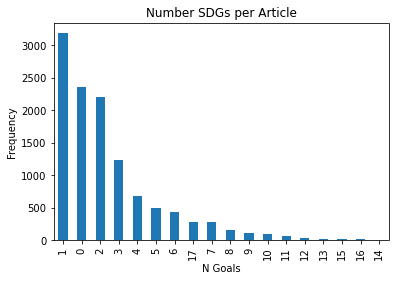

In [9]:
df_sdg['n_goals'] = [len(x) for x in df_sdg['sdg_goals']]

fig, ax = plt.subplots()
df_sdg['n_goals'].value_counts().plot.bar(ax=ax)
ax.set_title('Number SDGs per Article')
ax.set_xlabel('N Goals')
ax.set_ylabel('Frequency');

In [10]:
df_sdg = df_sdg[(df_sdg['n_goals'] > 0) & (df_sdg['n_goals'] < 4)]

In [11]:
sdg_counts = pd.Series(chain(*df_sdg['sdg_goals'])).map(sdg_definitions).value_counts()

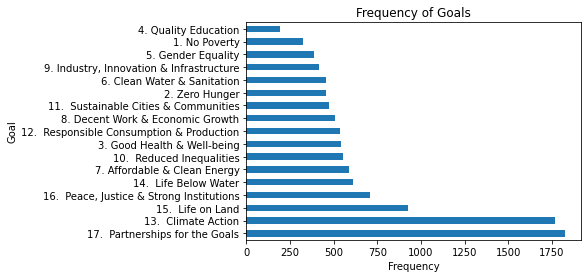

In [12]:
sdg_counts = pd.Series(chain(*df_sdg['sdg_goals'])).map(sdg_definitions).value_counts()

fig, ax = plt.subplots()
sdg_counts.plot.barh(ax=ax)
ax.set_title('Frequency of Goals')
ax.set_xlabel('Frequency')
ax.set_ylabel('Goal');

In [13]:
df_sdg = df_sdg[[False if 17 in x else True for x in df_sdg['sdg_goals']]]

In [14]:
sdg_counts = pd.Series(chain(*df_sdg['sdg_goals'])).map(sdg_definitions).value_counts()

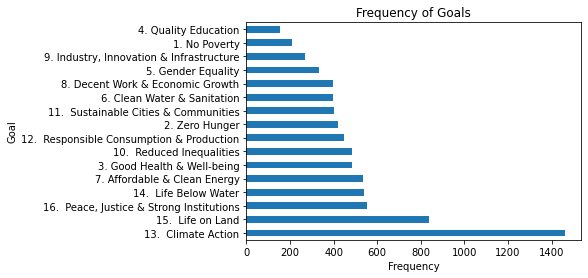

In [15]:
fig, ax = plt.subplots()
sdg_counts.plot.barh(ax=ax)
ax.set_title('Frequency of Goals')
ax.set_xlabel('Frequency')
ax.set_ylabel('Goal');

### Text

We need to make sure that there is enough text in each article to provide a rich enough source of information for each SDG. We will have a look at the distribution of text lengths.

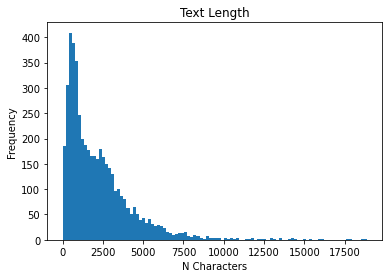

In [16]:
fig, ax = plt.subplots()
ax.hist(df_sdg['text'].str.len(), bins=100)
ax.set_title('Text Length')
ax.set_xlabel('N Characters')
ax.set_ylabel('Frequency');

Let's drop any texts that aren't at least the length of an old school tweet (clearly the minimum amount of characters required to convey any meaningful chunk of information in the 21st Century) and any duplicate texts.

In [17]:
df_sdg = df_sdg[df_sdg['text'].str.len() > 140]
df_sdg = df_sdg.drop_duplicates('text')
df_sdg = df_sdg.drop('index', axis=1)
df_sdg = df_sdg.reset_index()

In [18]:
df_sdg.shape

(4640, 7)

# SDG Classifier

## Text Preprocessing

### Tokenisation

Typically, for computers to understand human language, it needs to be broken down in to components, e.g. sentences, syllables, or words.

In the case of this work, we are going to analyse text at the word level. In natural language processing, the componenets below the sentence level are called **tokens**. The process of breaking a piece of text into tokens is called **tokenisation**. A token could be a word, number, email address or punctuation, depending on the exact tokenisation method used.

For example, tokenising the  `'The dog chased the cat.'` might give `['The', 'dog', 'chased', 'the', 'cat', '.']`.

In this case we will apply some extra processing during the tokenisation phase. We will

1. Tokenise each document at the word level.
2. Remove punctuation.
3. Remove **stop words**, such as `the`, `and`, `to` etc.
4. Apply lower case to all tokens.


❓What are some potential challenges with tokenization?

In [26]:
from im_tutorials.features.text_preprocessing import *

In [29]:
import nltk

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
nltk.punkt

<module 'nltk.tokenize.punkt' from 'c:\\users\\alex\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\nltk\\tokenize\\punkt.py'>

In [36]:
tokenized = [list(chain(*tokenize_document(document))) for document in df_sdg['text'].values]

In [37]:
doc_id = 0
n_tokens_print = 10

print('Original text of first document:')
print(df_sdg['text'].values[0], '\n')

print(f'First {n_tokens_print} tokens in first document {doc_id}:')
print(tokenized[doc_id][:n_tokens_print])

Original text of first document:
This chapter examines the growth of solar photovoltaic (PV) power across regions and countries, from the early 2000s until the current period. It will identify the countries where the initial solar PV development began and the countries where development is currently growing. The chapter will also assess the likely future path of solar PV in the coming years and offer some predictions as to how and where future growth will take place. This will entail an analysis of the drivers of deployment in the past, present, and future. Finally, the chapter will examine the breakdown of the types of deployment by segment, offering views on their future development. 

First 10 tokens in first document 0:
['chapter', 'examines', 'growth', 'solar', 'photovoltaic', 'power', 'across', 'regions', 'countries', 'early']


### Lemmatization

In many languages, words can have a root which can be modified with suffixes or appendixes or other methods.

We can use **lemmatization** to try to extract the root of most words.

❓Why is this useful?

❓What could go wrong?

In [38]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
wnl = WordNetLemmatizer()
lemmatized = [[wnl.lemmatize(t) for t in b] for b in tokenized]

In [40]:
doc_id = 0
n_tokens_print = 10

print(f'First {n_tokens_print} tokens in first document {doc_id}:')
print(tokenized[doc_id][:n_tokens_print], '\n')

print(f'First {n_tokens_print} lemmas in first document {doc_id}:')
print(lemmatized[doc_id][:n_tokens_print])

First 10 tokens in first document 0:
['chapter', 'examines', 'growth', 'solar', 'photovoltaic', 'power', 'across', 'regions', 'countries', 'early'] 

First 10 lemmas in first document 0:
['chapter', 'examines', 'growth', 'solar', 'photovoltaic', 'power', 'across', 'region', 'country', 'early']


### Term Frequencies

As well as stop words and punctuation, there may be other words that we want to remove, which are unique to our corpus. Often these are the tokens which appear very often and therefore convey little distinguishing information about each document.

Let's count up all of the tokens in our processed corpus and see which are the most common.

In [41]:
lemma_counts = Counter(chain(*lemmatized))
lemma_counts.most_common(50)

[('development', 8692),
 ('climate', 7137),
 ('country', 6517),
 ('sustainable', 6453),
 ('report', 5649),
 ('global', 5527),
 ('energy', 5103),
 ('change', 4788),
 ('also', 4536),
 ('international', 4311),
 ('action', 4056),
 ('world', 3977),
 ('water', 3960),
 ('sdg', 3568),
 ('meeting', 3452),
 ('policy', 3240),
 ('including', 3191),
 ('support', 3125),
 ('implementation', 2963),
 ('national', 2827),
 ('new', 2826),
 ('conference', 2824),
 ('government', 2819),
 ('agreement', 2748),
 ('goal', 2698),
 ('sdgs', 2675),
 ('state', 2629),
 ('agenda', 2613),
 ('organization', 2582),
 ('target', 2560),
 ('need', 2414),
 ('food', 2332),
 ('health', 2332),
 ('people', 2265),
 ('system', 2198),
 ('environment', 2162),
 ('session', 2133),
 ('programme', 2128),
 ('work', 2119),
 ('management', 2118),
 ('party', 2118),
 ('event', 2102),
 ('economic', 2072),
 ('group', 2072),
 ('ocean', 2067),
 ('land', 2061),
 ('sector', 2055),
 ('resource', 2040),
 ('process', 1980),
 ('paris', 1973)]

In [42]:
removes = ['development', 'country', 'report', 'also', 'action', 'sdg', 'meeting', 'policy', 'including', 'support',
          'implementation', 'national', 'new', 'conference', 'government', 'agreement', 'sdgs', 'goal', 'state',
          'agenda', 'organization', 'target', 'need', 'system', 'session', 'programme', 'management', 'party',
          'event', 'sector', 'process']

In [43]:
min_frequency = 5

df_sdg['clean_texts'] = [' '.join([t for t in doc if (t not in removes) & (lemma_counts[t] >= min_frequency)]) 
                     for doc in lemmatized] 


In [44]:
doc_id = 0
print(df_sdg['clean_texts'][doc_id])

chapter examines growth solar photovoltaic power across region early current period identify initial solar began currently growing chapter ass likely future path solar coming year offer prediction future growth take place entail analysis driver deployment past present future finally chapter examine breakdown type deployment segment offering view future


### From Natural to Machine Language

Once we have preprocessed our text, we can apply various NLP techniques to further process, analyse, summarise the text, extract information from it, or use it as features in a later analysis.

#### Bag of Words

In general, when dealing with text, we need to somehow convert it in to numeric data that can be processed and analysed using mathematics. A very simple example would be to count the number of times each token appears in a document. For example if we have the sentence `'I like really cute cats, but all cats are cute really.'`, after pre-processing and tokenisation, we could generate a vector of word counts where each position represents the token count:

```
vector      token
[1,         i
 1,         like
 2,         really
 2,         cute
 2,         cats
 1,         but
 1,         all
 1,]        are
```

This method is called the **bag of words** approach, and in this case we can determine that the document is about really cute cats. But in real life, with many documents, things are not always so straightfoward.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

In [46]:
count_vectorizer = CountVectorizer()
bow_vecs = count_vectorizer.fit_transform(df_sdg['clean_texts'])

In [47]:
vocab = np.array(count_vectorizer.get_feature_names())

In [48]:
doc_id = 0
n_top_terms = 10

def get_vec_counts(bow, idx):
    return np.array(bow.todense()[idx])[0]

def get_top_terms(bow, doc_id):
    vec_counts = get_vec_counts(bow, doc_id)
    topn = np.argsort(vec_counts)[::-1][:n_top_terms]
    top_counts = vec_counts[topn]
    top_terms = vocab[topn]
    return top_terms, top_counts

top_terms, top_counts = get_top_terms(bow_vecs, doc_id)

for term, count in zip(top_terms, top_counts):
    print(count, term)

4 future
3 solar
3 chapter
2 growth
2 deployment
1 view
1 ass
1 path
1 growing
1 currently


❓What are some potential limitations of bag of words?

#### Tf-Idf

An improvement on the simple bag of words is to somehow weight each token by it's importance, or how much information it carries. One way to to do this is by weighting the count of each word in a document with the inverse of its frequency across _all_ documents. This is called **term frequency-inverse document frequency** or **tf-idf**.

By doing this, a reasonably common word like `'height'` would probably be weighted lower than a less common, but more specific term such as `'altitude'`. Even if we have a document where height is mentioned more frequently than altitude, tf-idf can help us to identify that the document is referring to height in the context of altitude, rather than for example the height of a person.

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer

In [50]:
tfidf = TfidfTransformer()
tfidf_vecs = tfidf.fit_transform(bow_vecs)

In [51]:
doc_id = 0
n_top_terms = 10

top_terms, top_counts = get_top_terms(tfidf_vecs, doc_id)

print('Score Term')
for term, count in zip(top_terms, top_counts):
    print(f'{count:.3f}', term)

Score Term
0.399 chapter
0.363 solar
0.310 future
0.275 deployment
0.194 breakdown
0.188 entail
0.179 prediction
0.175 growth
0.159 photovoltaic
0.157 offering


We can now see that terms that are much more specific are weighted relatively higher than those which convey higher level and more generic information.

### Visualising Docs

Now that we have our documents described as vectors, we can visualise them!

To do this, we will need to project the high-dimensional document vectors in to low-dimensional space, in this case 2D.

In [52]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

SVD takes our sparse tf-idf vectors and compresses them in to a lower dimensional space.

In [55]:
svd = TruncatedSVD(n_components=30)
svd_vecs = svd.fit_transform(tfidf_vecs)

TSNE does a further projection in to 2 dimensional space. It tries to strike a balance between retaining local and global structure, making it good for visualisation.

In [56]:
tsne = TSNE(n_components=2)
tsne_vecs = tsne.fit_transform(svd_vecs)

In [57]:
single_goals = (df_sdg['n_goals'] == 1).index.values

In [58]:
tsne_vecs_single = tsne_vecs[single_goals]
goal_labels_single = [g[0] for g in df_sdg['sdg_goals'][single_goals]]
titles_single = df_sdg['title'][single_goals].values

In [59]:
from bokeh.models import HoverTool
from bokeh.palettes import Category20_16

In [60]:
colors = [Category20_16[g-1] for g in goal_labels_single]

cds = ColumnDataSource(data={
    'tsne_0': tsne_vecs[:, 0],
    'tsne_1': tsne_vecs[:, 1],
    'color': colors,
    'goal': [sdg_definitions[g] for g in goal_labels_single],
    'title': titles_single
})

p = figure(width=900, title='TSNE Plot of Single SDG Article Vectors')

hover = HoverTool(tooltips=[('Goal', '@goal'), ('Title', '@title')])

p.circle(source=cds, x='tsne_0', y='tsne_1', color='color', line_width=0, legend='goal', radius=0.4, alpha=0.9)
p.add_tools(hover)

show(p)
# output_notebook()

❓Does this visualisation have implications for our classification problem?

## Classification Model

Now that we have preprocessed and seen how to vectorized our text, it is time to build and train our model.

In this case, our **features** are the vectors created from the documents and our **target labels** are the SDG goals.

### Training Labels

This is a **multi-class** **multi-label** classification problem. This means that we have more than two possible labels - one for each of the SDGs - and each document can have more than one label assigned to it.

To train a model that can deal with this situation, we first need to transform our labels into binary features.

In [61]:
from sklearn.preprocessing import MultiLabelBinarizer

In [62]:
sdg_classes = list(range(1, 17))
mlb = MultiLabelBinarizer(classes=sdg_classes)

In [63]:
sdg_goals_mlb = pd.DataFrame(mlb.fit_transform(df_sdg['sdg_goals']), columns=mlb.classes_)

In [66]:
sdg_goals_mlb

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4635,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4636,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4637,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4638,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We can count up the goals again just to make sure that we've done the right thing.

In [65]:
sdg_goals_mlb.sum()

1      205
2      413
3      452
4      150
5      327
6      389
7      521
8      366
9      258
10     455
11     391
12     434
13    1443
14     527
15     829
16     531
dtype: int64

Looks ok!

Now we can also look to see whether there are any patterns between the SDGs.

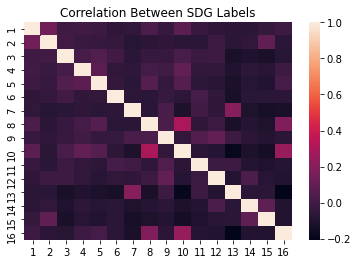

In [67]:
fig, ax = plt.subplots()
sns.heatmap(sdg_goals_mlb.corr(),ax=ax)
ax.set_title('Correlation Between SDG Labels');

### Train Test Split

To test the accuracy of our model, we will need to test it on data that is also labelled, but that it has not been trained with.

As we do not have a separate test dataset for this, we will hold back some of the original data with a train-test split.

In [68]:
from sklearn.model_selection import train_test_split

We are going to hold back 20% of our data for the test set.

In [69]:
tfidf_vecs_train, tfidf_vecs_test, sdg_labels_train, sdg_labels_test = train_test_split(
    tfidf_vecs, sdg_goals_mlb, test_size=0.2
)

print('Training set length:', tfidf_vecs_train.shape[0])
print('Test set length:', tfidf_vecs_test.shape[0])

Training set length: 3712
Test set length: 928


### A Quick Example

In [70]:
from sklearn.neighbors import KNeighborsClassifier

In [71]:
from sklearn.linear_model import LogisticRegression

knc = KNeighborsClassifier()
knc.fit(tfidf_vecs_train, sdg_labels_train)

KNeighborsClassifier()

In [72]:
preds = knc.predict(tfidf_vecs_test)

In [73]:
from sklearn.metrics import classification_report

In [74]:
print(classification_report(sdg_labels_test, preds, target_names=sdg_names[:-1]))

                                           precision    recall  f1-score   support

                            1. No Poverty       0.44      0.18      0.26        38
                           2. Zero Hunger       0.87      0.54      0.67       100
              3. Good Health & Well-being       0.88      0.53      0.66       106
                     4. Quality Education       0.88      0.42      0.57        36
                       5. Gender Equality       0.84      0.36      0.51        58
              6. Clean Water & Sanitation       0.93      0.74      0.82        69
             7. Affordable & Clean Energy       0.83      0.73      0.78       115
         8. Decent Work & Economic Growth       0.69      0.38      0.49        76
 9. Industry, Innovation & Infrastructure       0.80      0.23      0.36        52
                10.  Reduced Inequalities       0.84      0.59      0.69       104
    11.  Sustainable Cities & Communities       0.89      0.46      0.61        67
12.

c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Not great. It's not optimised.

### The Real Thing

Here we are going to train separate models for each SDG that will each be tuned with different parameters.

In [76]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
pipe = make_pipeline_imb(
    RandomUnderSampler(), 
    LogisticRegression(solver='lbfgs', fit_intercept=False)
)

C = np.logspace(-1, 2, 10)
strats = [0.5, 0.6, 0.7, 0.8]

params = {
    'randomundersampler__sampling_strategy': strats,
    'logisticregression__C': C,
}

grid = GridSearchCV(pipe, param_grid=params, cv=KFold(n_splits=3, shuffle=True))

We need to make all of the same vectorisation techniques we did before. We are also going to use SVD to create dense vectors.

In [80]:
tfidfv = TfidfVectorizer(ngram_range=(1,2))
tfidf_vecs = tfidfv.fit_transform(df_sdg['clean_texts'])

svdv = TruncatedSVD(n_components=300)
svd_vecs = svdv.fit_transform(tfidf_vecs)

svd_vecs_train, svd_vecs_test, sdg_labels_train, sdg_labels_test = train_test_split(
    svd_vecs, sdg_goals_mlb, test_size=0.2
)

In [81]:
classifiers = {}
preds = {}

for i in range(1, 17):
    print(sdg_definitions[i])
    grid.fit(svd_vecs_train, sdg_labels_train[i])
    best = grid.best_estimator_
    classifiers[i] = best
    preds[i] = best.predict(svd_vecs_test)
    print(classification_report_imbalanced(sdg_labels_test[i], preds[i]))
    print('\n')

1. No Poverty
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.98      0.39      0.98      0.62      0.40       887
          1       0.47      0.39      0.98      0.43      0.62      0.36        41

avg / total       0.95      0.95      0.42      0.95      0.62      0.40       928



2. Zero Hunger
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.99      0.53      0.97      0.72      0.54       850
          1       0.84      0.53      0.99      0.65      0.72      0.50        78

avg / total       0.95      0.95      0.56      0.95      0.72      0.54       928



3. Good Health & Well-being
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.98      0.69      0.98      0.82      0.69       839
          1       0.82      0.69      0.98      0.75      0.82      0.65        89

avg / total       

❓What might be limiting the accuracy of these classifiers?

## Gateway to Research Projects

Gateway to Research is a database of UK funded research projects across all disciplines. This sample of their database contains titles, abstracts, research categories and the start year for each project.

We are going to apply our SDG classifier to the abstracts and then have a look at some possible analysis methods.

In [85]:
import ast

In [88]:
import im_tutorials.data.gtr as datasets

In [86]:
#df_gtr = datasets.gateway_to_research_projects()

NameError: name 'datasets' is not defined

In [89]:
df_gtr = datasets.gtr_sample()

c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\smart_open\smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [90]:
df_gtr.head()

,project_id,start_year,research_topics,research_subjects,abstract_texts,funder_name
0,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B391...,2010,[Statistics & Appl. Probability],[Mathematical sciences],Random fields of gradients are a class of mode...,EPSRC
1,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B3F5...,2016,"[Political Science, European/EU Studies, Polit...",[Pol. sci. & internat. studies],Can the EU govern efficiently and with the peo...,ESRC
2,http://gtr.rcuk.ac.uk:80/gtr/api/projects/D894...,2008,"[Materials Characterisation, High Performance ...","[Materials sciences, Supercond, magn. &quant.f...",Many technological advances in modern day life...,EPSRC
3,http://gtr.rcuk.ac.uk:80/gtr/api/projects/D99D...,2006,"[Management & Business Studies, Economic & Soc...","[Management & Business Studies, History, Econo...",<p>This research programme groups together 7 p...,ESRC
4,http://gtr.rcuk.ac.uk:80/gtr/api/projects/4756...,2013,"[Phenomenology, The Standard Model, Beyond the...","[Particle physics - experiment, Particle Astro...",Experimental particle physics addresses fundam...,STFC


In [91]:
df_gtr.shape

(42584, 6)

c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


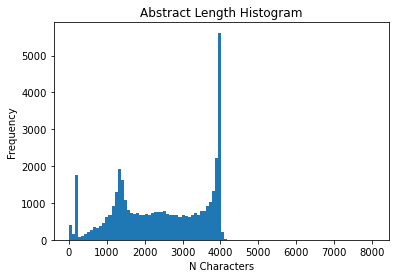

In [92]:
fig, ax = plt.subplots()
ax.hist(df_gtr['abstract_texts'].str.len(), bins=100)
ax.set_title('Abstract Length Histogram')
ax.set_xlabel('N Characters')
ax.set_ylabel('Frequency');

In [93]:
df_gtr['abstract_texts'].value_counts()[:3]

Abstracts are not currently available in GtR for all funded research. This is normally because the abstract was not required at the time of proposal submission, but may be because it included sensitive information such as personal details.    1655
Equipment only, agreed in relation to the previously issued GridPP4 grant.                                                                                                                                                                           24
Refer to ATLAS-UK upgrade proposal to PPRP: &quot;UPGRADING THE ATLAS EXPERIMENT FOR THE LUMINOSITY FRONTIER AT THE LARGE HADRON COLLIDER&quot; PPRP meeting, September 2012                                                                         22
Name: abstract_texts, dtype: int64

In [94]:
df_gtr.groupby('start_year')['project_id'].count()

start_year
1975       1
1978       1
1979       3
1980       1
1981       1
1983       3
1984       1
1987       1
1988       3
1989       2
1990       1
1991       3
1992       2
1993       7
1994       7
1995       5
1996       9
1997      17
1998      29
1999      34
2000      30
2001      85
2002      97
2003     108
2004     222
2005     412
2006    4075
2007    4252
2008    4008
2009    3610
2010    3602
2011    2992
2012    3620
2013    3703
2014    3320
2015    3196
2016    3243
2017    1868
2018       9
2019       1
Name: project_id, dtype: int64

In [95]:
df_gtr = df_gtr[(df_gtr['start_year'] > 2005) & (df_gtr['start_year'] < 2018)]
text_drop = df_gtr['abstract_texts'].value_counts().index[0]
df_gtr = df_gtr[~pd.isnull(df_gtr['abstract_texts'])]
df_gtr = df_gtr[df_gtr['abstract_texts'].str.len() > 140]
df_gtr = df_gtr[df_gtr['abstract_texts'] != text_drop]
df_gtr = df_gtr.sort_values('start_year')
df_gtr = df_gtr.reset_index()
df_gtr = df_gtr.drop('index', axis=1)

In [96]:
df_gtr.shape

(39893, 6)

### Apply Text Preprocessing

In [97]:
tokenized_gtr = [list(chain(*tokenize_document(document))) for document in df_gtr['abstract_texts'].values]
lemmatized_gtr = [[wnl.lemmatize(t) for t in b] for b in tokenized_gtr]
df_gtr['clean_texts'] = [' '.join(t) for t in lemmatized_gtr]

### Apply Model

In [98]:
tfidf_gtr = tfidfv.transform(df_gtr['clean_texts'])
svd_gtr = svdv.transform(tfidf_gtr)
sdgs_gtr = {}
for i, clf in classifiers.items():
    sdgs_gtr[i] = clf.predict(svd_gtr)

### Explore Results

In [99]:
df_gtr_sdgs = pd.DataFrame(sdgs_gtr)
df_gtr_sdgs.columns = [sdg_definitions[i] for i in df_gtr_sdgs.columns]
df_gtr_sdgs.sum(axis=0)

1. No Poverty                                 148
2. Zero Hunger                                785
3. Good Health & Well-being                  6133
4. Quality Education                          944
5. Gender Equality                            470
6. Clean Water & Sanitation                   805
7. Affordable & Clean Energy                 2862
8. Decent Work & Economic Growth              140
9. Industry, Innovation & Infrastructure      846
10.  Reduced Inequalities                     295
11.  Sustainable Cities & Communities         501
12.  Responsible Consumption & Production    4049
13.  Climate Action                          2798
14.  Life Below Water                        1354
15.  Life on Land                            1462
16.  Peace, Justice & Strong Institutions     604
dtype: int64

In [100]:
topic_count = Counter(chain(*df_gtr['research_topics']))
subject_count = Counter(chain(*df_gtr['research_subjects']))
print('N Topics:', len(topic_count))
print('N Subjects:', len(subject_count))

N Topics: 607
N Subjects: 82


In [101]:
rs = sorted(set(chain(*df_gtr['research_subjects'])))
mlb_subjects = MultiLabelBinarizer(classes=rs)
subjects_mlb_df = mlb_subjects.fit_transform(df_gtr['research_subjects'])
subjects_mlb_df = pd.DataFrame(subjects_mlb_df, columns=rs)

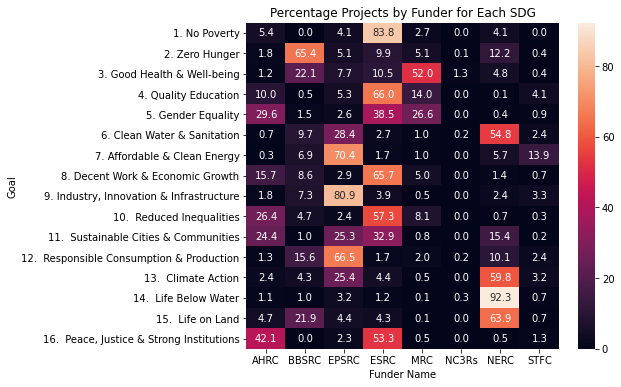

In [102]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap((df_gtr_sdgs.groupby(df_gtr['funder_name']).sum() / 
 df_gtr_sdgs.groupby(df_gtr['funder_name']).sum().sum() * 100).T, ax=ax,
           annot=True, fmt='.1f')
ax.set_title('Percentage Projects by Funder for Each SDG')
ax.set_xlabel('Funder Name')
ax.set_ylabel('Goal');

### Correlation With Research Subjects

In [103]:
from scipy.stats import pearsonr

In [104]:
sdg_subj_corrs = np.zeros((subjects_mlb_df.shape[1], len(sdg_names) -1))

for i, subj in enumerate(subjects_mlb_df.columns):
    for j, sdg in enumerate(df_gtr_sdgs.columns):
        corr = pearsonr(subjects_mlb_df[subj], df_gtr_sdgs[sdg])[0]
        sdg_subj_corrs[i, j] = corr
        
sdg_subj_corrs_df = pd.DataFrame(sdg_subj_corrs,
                                 columns=df_gtr_sdgs.columns,
                                 index=subjects_mlb_df.columns)

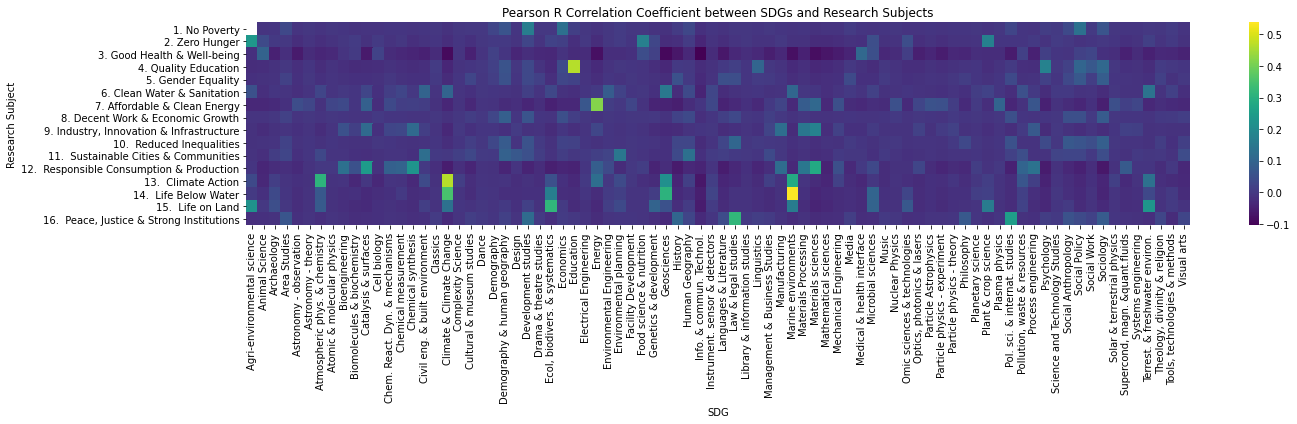

In [105]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(sdg_subj_corrs_df.T, ax=ax, cmap='viridis')
ax.set_title('Pearson R Correlation Coefficient between SDGs and Research Subjects')
ax.set_xlabel('SDG')
ax.set_ylabel('Research Subject');
plt.tight_layout();

### SDGs Over Time

In [106]:
rolling_window = 3
sdgs_time_df = (
    (df_gtr_sdgs.groupby(df_gtr['start_year']).sum().loc[2006:2017].divide( 
     df_gtr.groupby('start_year')['project_id'].count().loc[2006:2017].values, axis=0) * 100)
     .rolling(rolling_window).mean())

In [107]:
p2 = figure(title='Percentage of GtR Projects by SDG over Time', width=900, height=500)

for i, col in enumerate(sdgs_time_df.columns):
    color = Category20_16[i-1]
    p2.line(
        x=sdgs_time_df.index.values, 
        y=sdgs_time_df[col],
        color=color,
        line_width=3,
        alpha=0.8,
        legend=col,
        muted_color=color,
        muted_alpha=0.3
    )

p2.legend.location = "top_left"
p2.legend.click_policy="mute"
p2.legend.label_text_font_size = '6pt'

show(p2)

❓What are the caveats behind this plot?

## Changes in Term Correlation

With our projects classified, we can hone in on individual SDGs.

Here's a simple example where we look at which new terms are highly correlating each year with SDG 7. Affordable & Clean Energy.

In [108]:
from sklearn.feature_selection import SelectKBest

In [109]:
ngram_range = (1, 1)

found = set()
for year, group in df_gtr.groupby('start_year'):
    print('===', year, '===')
    tfidf_corr = TfidfVectorizer(ngram_range=ngram_range)
    tfidf_corr_vecs = tfidf_corr.fit_transform(group['clean_texts'])
    
    ids = group.index.values
    sdg_labels = df_gtr_sdgs[sdg_names[6]].iloc[ids]
    skb = SelectKBest(k=20)
    vocab_corr = {v: k for k, v in tfidf_corr.vocabulary_.items()}
    skb.fit(tfidf_corr_vecs, df_gtr_sdgs[sdg_names[6]].values[ids])
    top_term_ids = np.argsort(np.nan_to_num(skb.scores_, 0))[::-1][0:50]
    top_terms = [vocab_corr[v] for v in top_term_ids]
    not_found_before = [t for t in top_terms if t not in found]
    found.update(top_terms)
    print(not_found_before)

=== 2006 ===
['energy', 'fuel', 'electricity', 'renewable', 'power', 'hydrogen', 'dioxide', 'efficiency', 'muck', 'deforestation', 'reconvert', 'c_cycle', 'biomass', 'there', 'incinerator', 'fossil', 'buliding', 'absorb', 'backup', 'oil', 'dark', 'converted', 'unbalanced', 'alarming', 'ray', 'drastic', 'polynuclear', 'powering', 'dwindling', 'gamma_ray', 'renewables', 'collider', 'conversion', 'decreasing', 'carbon_free', 'bioethanol', 'saying', 'heat', 'syngas', 'colliding', 'electron', 'petrochemical', 'released', 'battery', 'sorption', 'sunlight', 'crude', 'esdu', 'asphaltenic', 'sub_projectd']
=== 2007 ===
['solar', 'high', 'photovoltaic', 'sealing', 'storage', 'compiler', 'retrosynthesis', 'atomically', 'nano_assembler', 'pick', 'material', 'electrolyte', 'spm', 'foresight', 'photovoltaics', 'clean', 'gasification', 'thermal', 'wind', 'roof', 'nuclear', 'technology', 'proton', 'cost', 'photoelectrochemistry', 'corus', 'manufacturability', 'dsscs', 'dssc', 'ocs', 'light_to_electric

❓How could we improve on this method to find the most emerging terms associated with the SDG?

#### An Aside on N Grams

We know that some in some cases, we might have words that appear together more often than we might expect. This might happen where we have commonly used phrases, or names of entities, for example `general relativity`. It can be useful to identify cases of this in our text so that the machine can understand that they represent different information when compared to the words appearing separately. Tokens of multiple words are called **n grams**. N grams containing two tokens are **bigrams**, n grams containing three words are **trigrams** and so on.

For example, in a corpus of text, we might have the sentence, `'I travelled from York to New York to find a new life.'`. After tokenisation and finding bigrams, we might end up with `['i', 'travelled', 'from', 'york', 'to', 'new_york', 'to', 'find', 'a', 'new', 'life', '.']`.

## Topics for Renewable Energy

#### Topic Modelling

When we have thousands of documents, it can be too many for a single person to read and understand in a reasonable space of time. A useful first step is often to be able to understand what the main themes are within the documents we have. Bag of words or tf-idf are useful processing methods, but they still require us to inspect each document individually or group them and identify topics manually. 

Luckily, there are automated methods of finding the groups of tokens that describe broad themes within a set of documents, which are referred to as **topic modelling**.

In this case, we are going to use **Latent Semantic Indexing** or **LSI**.

In [110]:
df_sdg_7 = df_gtr[(df_gtr_sdgs[sdg_names[6]] == 1)]

In [111]:
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser, Phrases
from gensim.models.lsimodel import LsiModel
from gensim.sklearn_api.lsimodel import LsiTransformer

In [112]:
sdg_7_tokenised = [list(chain(*tokenize_document(document))) for document in df_sdg_7['clean_texts'].values]

In [113]:
dictionary = Dictionary(sdg_7_tokenised)
dictionary.filter_extremes(no_above=0.2)

In [114]:
bow_sdg_7 = [dictionary.doc2bow(d) for d in sdg_7_tokenised]

In [115]:
num_topics = 300
lsi = LsiModel(bow_sdg_7, id2word=dictionary, num_topics=num_topics)

In [116]:
n_topics_print = 10

for topic_id in range(0, num_topics, int(num_topics/n_topics_print)):
    print('Topic', topic_id)
    print(lsi.print_topic(topic_id), '\n')

Topic 0
0.179*"solar" + 0.142*"particle" + 0.123*"electron" + 0.115*"light" + 0.110*"storage" + 0.100*"electricity" + 0.099*"heat" + 0.096*"plasma" + 0.095*"building" + 0.094*"control" 

Topic 30
0.403*"surface" + -0.193*"quantum" + 0.191*"air" + 0.185*"engine" + -0.167*"food" + -0.143*"molecule" + -0.143*"fat" + -0.135*"state" + -0.128*"telescope" + 0.127*"protein" 

Topic 60
-0.234*"polymer" + 0.196*"water" + 0.157*"grid" + -0.154*"reaction" + -0.145*"manufacturing" + -0.122*"product" + -0.117*"amp" + 0.117*"electricity" + -0.116*"crop" + -0.111*"climate" 

Topic 90
0.155*"supply" + -0.154*"beam" + 0.145*"capture" + 0.141*"reaction" + 0.132*"solution" + -0.131*"polymer" + -0.126*"noise" + 0.125*"structural" + -0.120*"state" + -0.113*"ion" 

Topic 120
-0.181*"activity" + -0.170*"engineering" + 0.138*"information" + 0.132*"oxygen" + -0.116*"semiconductor" + 0.113*"flow" + -0.107*"dioxide" + -0.105*"local" + 0.104*"car" + -0.101*"behaviour" 

Topic 150
-0.155*"developing" + 0.151*"dioxi

❓Do these topics reveal anything to you about the challenges of using machine learning methods exploring research topics?

In [117]:
svd_7 = TruncatedSVD(n_components=30)
svd_7_vecs = svd_7.fit_transform(lsi_vecs)
tsne_7 = TSNE(n_components=2)
tsne_7_vecs = tsne_7.fit_transform(svd_7_vecs)

NameError: name 'lsi_vecs' is not defined

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agc = AgglomerativeClustering(n_clusters=20, affinity='cosine', linkage='complete')
agcs = agc.fit_predict(svd_7_vecs)

In [ ]:
def make_topic_terms(model, num_topic_terms):
    topic_terms = []
    for i in range(model.num_topics):
        topic_terms.append([t[0] for t 
                   in model.show_topic(i)[:num_topic_terms]])        
    return np.array(topic_terms)

def make_topic_names(topic_vectors, topic_terms, num_topics=None):
    topic_names = []
    for vector in topic_vectors:
        topic_ids = np.argsort(vector)[::-1][:num_topics]
        name = ', '.join([c for c in chain(*topic_terms[topic_ids])])
        topic_names.append(name)
    return topic_names

topic_terms = make_topic_terms(lsi, 2)

topic_names = make_topic_names(lsi_vecs, topic_terms, num_topics=3)

In [ ]:
titles = [x[:50] for x in df_gtr.iloc[df_sdg_7.index.values]['clean_texts'].values]

cmap = matplotlib.cm.hsv
norm = matplotlib.colors.Normalize(vmin=np.min(agcs), vmax=np.max(agcs))
colors = [matplotlib.cm.colors.to_hex(cmap(norm(i))) for i in agcs]

cds = ColumnDataSource(data={'tsne_0': tsne_7_vecs[:, 0],
                             'tsne_1': tsne_7_vecs[:, 1],
                             'name': titles,
                             'color': colors,
                             'cluster': agcs})

p = figure(width=900)
hover = HoverTool(tooltips=[("Topic", "@name"), ("Cluster", "@cluster")])
p.circle(source=cds, x='tsne_0', y='tsne_1', fill_color='color', line_color='color', 
         fill_alpha=0.5, line_alpha=0.5, radius=.5)
p.add_tools(hover)

show(p)

# output_notebook()

### Topic Networks

#### Communities of Projects

Our topic modeled projects can now be projected in to space, and we can find nearnest neighbours using Cosine distance.

In [ ]:
df_sdg_7 = df_sdg_7.reset_index()
df_sdg_7 = df_sdg_7.drop('index',axis=1)

In [ ]:
from annoy import AnnoyIndex
from collections import defaultdict

In [ ]:
annoy_indices = {}
for year, group in df_sdg_7.groupby(['start_year']):
    ids = group.index.values

    vecs = svd_7_vecs[ids]
    t = AnnoyIndex(svd_7.n_components, 'angular')  # Length of item vector that will be indexed
    for idx, vec in zip(ids, vecs):
        t.add_item(idx, vec)
    t.build(500)
    annoy_indices[year] = t

In [ ]:
years = df_sdg_7['start_year'].unique()

In [ ]:
min_dist = 0.8

project_edges = defaultdict(list)

for year, group in df_sdg_7.groupby(['start_year']):
    edges_year = []
    ids = group.index.values
    annoy_index = annoy_indices[year]
    for idx in ids:
        for neighbour_idx in annoy_index.get_nns_by_item(idx, 30):
            if neighbour_idx == idx:
                continue
            else:
                dist = annoy_index.get_distance(neighbour_idx, idx)
                if dist < min_dist:
                    edges_year.append((idx, neighbour_idx, {'dist': 1 - dist}))
    project_edges[year].extend(edges_year)

In [ ]:
import networkx as nx

In [ ]:
g_p = nx.Graph()
g_p.add_edges_from(project_edges[2007])

g_p_node_pos = nx.spring_layout(g_p, seed=101, weight='dist')
nx.draw(g_p, pos=g_p_node_pos, node_size=15, node_color='C0');

In [ ]:
import community

In [ ]:
communities = community.best_partition(g_p, resolution=0.3, weight='dist')

In [ ]:
nx.draw(g_p, pos=g_p_node_pos, node_size=15, node_color=list(communities.values()), cmap=matplotlib.cm.hsv)

In [ ]:
resolution = 0.3

project_communities = {}
community_labels = {}
project_graphs = {}
for year, edge_list in project_edges.items():
    g = nx.Graph()
    g.add_edges_from(edge_list)
    project_graphs[year] = g
    
    communities = community.best_partition(g, resolution=resolution, weight='dist')
    print(f'N Communities at {year}:', len(set(communities.values())))
    
    community_ids = defaultdict(list)
    for proj, c in communities.items():
        community_ids[c].append(proj)
    project_communities[year] = community_ids

In [ ]:
svd_communities = {}

for year, communities_year in project_communities.items():
    svd_communities_year = []
    for community_id, docs in communities_year.items():
        mean_vec = np.mean(svd_7_vecs[docs], axis=0)
        mean_vec = mean_vec / np.max(mean_vec)
        svd_communities_year.append(mean_vec)
    svd_communities[year] = svd_communities_year

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
similarity_thresh = 0.5

agg_edges = []
max_parents = 1

for i, year in enumerate(sorted(years)):
    if i > 0:
        past_year = year - 1
        past_vecs = svd_communities[past_year]
        current_vecs = svd_communities[year]
        for idx, vec in enumerate(current_vecs):
            similarities = [1 - cosine(vec, c_past) for c_past in past_vecs]
            sim_max_ids = np.argsort(similarities)[::-1][:max_parents]
            for sim_max_idx in sim_max_ids:
                edge = (f'{year}_{idx}', f'{past_year}_{sim_max_idx}', {'weight': similarities[sim_max_idx]})
            agg_edges.append(edge)      

In [ ]:
nodes = []
for year, communities in project_communities.items():
    for idx, _ in enumerate(communities):
        nodes.append(f'{year}_{idx}')

In [ ]:
plt.hist([e[2]['weight'] for e in agg_edges], bins=50);

In [ ]:
h = nx.DiGraph()
h.add_nodes_from(nodes)
h.add_edges_from(agg_edges)

In [ ]:
pos_x = np.array([int(d.split('_')[0]) for d in h.nodes])
pos_x = pos_x - np.max(pos_x)

tsne_agg = TSNE(n_components=1)
svd_df = pd.DataFrame(np.array(list(chain(*svd_communities.values()))))
pos_y = tsne_agg.fit_transform(svd_df)

pos_y = pos_y - np.min(pos_y) 
pos_y = pos_y / np.max(pos_y)

pos = {}
for node, x, y in zip(h.nodes, pos_x, pos_y):
    pos[node] = (x, y[0])

In [ ]:
weights = np.array([1 / h.get_edge_data(e[0], e[1])['weight'] for e in h.edges])
weights = weights / np.max(weights)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
n_clusters = int(np.round(np.mean([len(c) for c in svd_communities.values()])))

km = KMeans(n_clusters=n_clusters)
km.fit(list(chain(*svd_communities.values())))
colors = km.labels_
cmap_nodes = matplotlib.cm.hsv

In [ ]:
cmap = matplotlib.cm.get_cmap('inferno')
fig, ax = plt.subplots(figsize=(15, 7.5))
nx.draw(h, pos=pos, node_size=50, edge_color=weights, edge_cmap=cmap, width=2, node_color=colors, cmap=cmap_nodes)

In [ ]:
lsi_vecs.shape

In [ ]:
top_n = 3

lsi_years = {}

for year, group in df_sdg_7.groupby(['start_year']):
    ids = group.index.values
    lsi_year = np.sqrt(np.square(lsi_vecs[ids]))
    lsi_mean = np.mean(lsi_year, axis=0)
    lsi_years[year] = lsi_mean

In [ ]:
lsi_df = pd.DataFrame(lsi_years).T.rolling(3).mean()

In [ ]:
# megs = lsi_df.multiply(df_sdg_7.groupby('start_year')['project_id'].count(), axis=0)

In [ ]:
n_topics = 10

fig, axs = plt.subplots(nrows=n_topics, figsize=(6, 1.2 * n_topics))

for i, ax in enumerate(axs):
    ax.plot(lsi_df[i], linewidth=2)
    title = ' '.join([c[0] for c in lsi.show_topic(i)][:5])
    ax.set_title(title)

plt.tight_layout()

### Topic Centrality

In [ ]:
co_edges = []
for i, vec in enumerate(lsi_vecs):
    top_topics = np.argsort(vec)[::-1][:top_n]
    for combo in combinations(top_topics, 2):
        co_edges.append(tuple(sorted(combo)))
co_edges = list(set(co_edges))

g_topic_co = nx.Graph()
g_topic_co.add_edges_from(co_edges)

b = np.array(list(nx.centrality.betweenness_centrality(g_topic_co)))
d = np.array(list(nx.centrality.degree_centrality(g_topic_co).values())) * 100

cmap = matplotlib.cm.inferno
norm = matplotlib.colors.Normalize(vmin=np.min(b), vmax=np.max(b))
colors = [cmap(norm(i)) for i in b]
nx.draw(g_topic_co, node_size=d, node_color=colors, edge_color='gray')